# Projeto de Classificação para Marinha do Brasil

## Autor: Natanael Junior (natmourajr@gmail.com)

Laboratório de Processamento de Sinais - UFRJ

Laboratório de Tecnologia Sonar

Instituto de Pesquisas da Marinha - IPqM

# Bibliotecas e leitura dos dados
As bibliotecas necessárias para a inclusão

In [151]:
import os
import pickle
import numpy as np
import time

init_time = time.time()

from sklearn.externals import joblib

m_time = time.time()
print 'Time to import all libraries: %1.5f seconds'%(m_time-init_time)

outputpath = os.environ['OUTPUTDATAPATH']
main_analysis_path = os.environ['SONAR_WORKSPACE']
log_analysis_path = os.environ['PACKAGE_OUTPUT']
result_analysis_path = os.environ['PACKAGE_OUTPUT']+'/PCASingleClassSVM'
# Read data
# Check if LofarData has created...
m_time = time.time()


subfolder = '4classes_old'
n_pts_fft = 1024
decimation_rate = 3

if(not os.path.exists(outputpath+'/'+'LofarData_%s_%i_fft_pts_%i_decimation_rate.jbl'%(
            subfolder,n_pts_fft,decimation_rate))):
    print outputpath+'/'+'LofarData_%s_%i_fft_pts_%i_decimation_rate.jbl'%(
        subfolder,n_pts_fft,decimation_rate)+' doesnt exist...please create it'
    exit()
    
#Read lofar data
[data,class_labels] = joblib.load(outputpath+'/'+'LofarData_%s_%i_fft_pts_%i_decimation_rate.jbl'%(
            subfolder,n_pts_fft,decimation_rate))

m_time = time.time()-m_time
print 'Time to read data file: %1.5f seconds'%m_time

Time to import all libraries: 0.00004 seconds
Time to read data file: 1.65417 seconds


# Processamento dos dados
Os dados encontram-se no formato do matlab, para isso precisam ser processados para o formato de python.

In [152]:
# Process data...
# create a full data vector
all_data = {};
all_trgt = {};

for iclass, class_label in enumerate(class_labels):
    for irun in range(len(data[iclass])):
        if len(all_data) == 0:
            all_data = data[iclass][irun]['Signal']
            all_trgt = (iclass)*np.ones(data[iclass][irun]['Signal'].shape[1])
        else:
            all_data = np.append(all_data,data[iclass][irun]['Signal'],axis=1)
            all_trgt = np.append(all_trgt,(iclass)*np.ones(data[iclass][irun]
                                                           ['Signal'].shape[1]),axis=0)
            
all_data = all_data.transpose()

# Balanceamento de Classes
Os dados encontram-se desbalanceados. Com isso, os classificadores podem se especializar em uma classe (gerando mais SVs para a mesma) e não se especializar em outras

Acessados em 21/12/2016

https://svds.com/learning-imbalanced-classes/

http://www.cs.utah.edu/~piyush/teaching/ImbalancedLearning.pdf

http://scikit-learn.org/stable/auto_examples/svm/plot_separating_hyperplane_unbalanced.html

Para solucionar isso, a primeira solução é "criar" dados das classes com menos eventos de maneira aleatória. Outras soluções podem ser propostas posteriormente.

In [153]:
# Process data
# unbalanced data to balanced data with random data creation of small classes

# Same number of events in each class
qtd_events_biggest_class = 0
biggest_class_label = ''

for iclass, class_label in enumerate(class_labels):
    if sum(all_trgt==iclass) > qtd_events_biggest_class:
        qtd_events_biggest_class = sum(all_trgt==iclass)
        biggest_class_label = class_label
    print "Qtd event of %s is %i"%(class_label,sum(all_trgt==iclass))
print "\nBiggest class is %s with %i events"%(biggest_class_label,qtd_events_biggest_class)


balanced_data = {}
balanced_trgt = {}

from Functions import DataHandler as dh
m_datahandler = dh.DataHandlerFunctions()

for iclass, class_label in enumerate(class_labels):
    if len(balanced_data) == 0:
        class_events = all_data[all_trgt==iclass,:]
        balanced_data = m_datahandler.CreateEventsForClass(
            class_events,qtd_events_biggest_class-(len(class_events)))
        balanced_trgt = (iclass)*np.ones(qtd_events_biggest_class)
    else:
        balanced_data = np.append(balanced_data,
                                  (m_datahandler.CreateEventsForClass(
                    all_data[all_trgt==iclass,:],
                    qtd_events_biggest_class-sum(all_trgt==iclass))),
                                  axis=0)
        balanced_trgt = np.append(balanced_trgt,
                                  (iclass)*np.ones(qtd_events_biggest_class),axis=0)
        
all_data = balanced_data
all_trgt = balanced_trgt

Qtd event of ClassA is 4312
Qtd event of ClassB is 9781
Qtd event of ClassC is 3833
Qtd event of ClassD is 7918

Biggest class is ClassB with 9781 events
DataHandler Class: CreateEventsForClass
Original Size: (4312, 400)
DataHandler Class: CreateEventsForClass
Original Size: (9781, 400)
DataHandler Class: CreateEventsForClass
Original Size: (3833, 400)
DataHandler Class: CreateEventsForClass
Original Size: (7918, 400)


# Definições do treinamento
Nessa célula temos os parâmetros do treinamento a ser realizado. No log, deve ficar armazenada a data do treinamento para a reconstrução dos resultados

In [29]:
%time

from sklearn import cross_validation
from Functions import LogFunctions as log

# Create a entry in log file
m_log = log.LogInformation()
date = m_log.CreateLogEntry("NoveltyDetection",'kPCASingleClassSVM')

# Create a train information file
n_folds = 2
n_kpcas = 10
norm = 'mapstd'
#nu_values = np.array([0.7, 0.8, 0.9])
#nu_values = np.array([0.001, 0.1, 0.2])
nu_values = np.array([0.001, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99])
gamma_value = 0.1

train_info = {}
train_info['n_folds'] = n_folds
train_info['n_kpcas'] = n_kpcas
train_info['norm'] = norm
train_info['nu_values'] = nu_values
train_info['gamma_value'] = gamma_value

# divide data in train and test for novelty detection
for novelty_class, novelty_label in enumerate(class_labels):
    print 'Dividing data in trn and tst for novelty class: %s'%(novelty_label)
    CVO = cross_validation.StratifiedKFold(all_trgt[all_trgt!=novelty_class], n_folds)
    CVO = list(CVO)
    train_info['CVO_novelty_%s'%(novelty_label)] = CVO

train_info['preprocessing_done'] = False
train_info['train_done'] = False
train_info['results_done'] = False

train_info_name = result_analysis_path+'/train_info_files'+'/'+date+'_train_info.jbl'
joblib.dump([train_info],train_info_name,compress=9)


CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 4.05 µs
Dividing data in trn and tst for novelty class: ClassA
Dividing data in trn and tst for novelty class: ClassB
Dividing data in trn and tst for novelty class: ClassC
Dividing data in trn and tst for novelty class: ClassD


['/home/natmourajr/Workspace/Doutorado/SonarAnalysis/Results/NoveltyDetection/PCASingleClassSVM/train_info_files/2017_02_12_03_31_51_train_info.jbl']

In [154]:
# Read log files
from Functions import LogFunctions as log
mlog = log.LogInformation()
log_entries = mlog.RecoverLogEntries(package_name="NoveltyDetection")
print log_entries

{0: {'date': '2016_12_01_17_27_33', 'package': 'PCASingleClassSVM'}, 1: {'date': '2016_12_01_17_51_48', 'package': 'PCASingleClassSVM'}, 2: {'date': '2016_12_01_18_09_34', 'package': 'PCASingleClassSVM'}, 3: {'date': '2016_12_01_18_25_15', 'package': 'PCASingleClassSVM'}, 4: {'date': '2016_12_01_19_09_08', 'package': 'PCASingleClassSVM'}, 5: {'date': '2016_12_21_15_11_02', 'package': 'PCASingleClassSVM'}, 6: {'date': '2016_12_21_15_14_37', 'package': 'PCASingleClassSVM'}, 7: {'date': '2016_12_22_14_02_05', 'package': 'PCASingleClassSVM'}, 8: {'date': '2016_12_22_14_03_23', 'package': 'PCASingleClassSVM'}, 9: {'date': '2016_12_22_14_13_41', 'package': 'PCASingleClassSVM'}, 10: {'date': '2016_12_22_14_14_45', 'package': 'PCASingleClassSVM'}, 11: {'date': '2016_12_22_15_27_30', 'package': 'PCASingleClassSVM'}, 12: {'date': '2016_12_22_16_33_54', 'package': 'PCASingleClassSVM'}, 13: {'date': '2016_12_22_17_02_55', 'package': 'PCASingleClassSVM'}, 14: {'date': '2016_12_22_17_13_21', 'packag

In [155]:
# Read Information of Train Info File
choose_date = '2017_02_12_03_31_51'

for log_id, log_entry in enumerate(log_entries):
    if log_entries[log_id]['package'] != 'kPCASingleClassSVM':
        continue
    if log_entries[log_id]['date'] != choose_date:
        continue
    print 'Analysing train performed in %s and for %s analysis'%(
        log_entries[log_id]['date'],log_entries[log_id]['package'])
    
    # Read train info file
    train_info_name = '%s/train_info_files/%s_train_info.jbl'%(
        result_analysis_path,log_entries[log_id]['date'])
    
    [train_info] = joblib.load(train_info_name)
    print 'kPCASingleClassSVM Train Info File'
    print 'Date: %s'%(choose_date)
    print 'Number of Folds: %i'%(train_info['n_folds'])
    print 'Number of Used kPCAs: %i'%(train_info['n_kpcas'])
    print 'Normalization Method: %s'%(train_info['norm'])
    print 'Gamma Value: %1.3f'%(train_info['gamma_value'])
    print 'Nu Value(s): '
    print train_info['nu_values']
    if train_info['preprocessing_done']:
        print 'Preprocessing Done: True'
    else:
        print 'Preprocessing Done: False'
    if train_info['train_done']:
        print 'Train Done: True'
    else:
        print 'Train Done: False'
    if train_info['results_done']:
        print 'Extract Results: True'
    else:
        print 'Extract Results: False'

Analysing train performed in 2017_02_12_03_31_51 and for kPCASingleClassSVM analysis
kPCASingleClassSVM Train Info File
Date: 2017_02_12_03_31_51
Number of Folds: 2
Number of Used kPCAs: 10
Normalization Method: mapstd
Gamma Value: 0.100
Nu Value(s): 
[ 0.001  0.1    0.2    0.3    0.4    0.5    0.6    0.7    0.8    0.9    0.99 ]
Preprocessing Done: True
Train Done: True
Extract Results: True


# Preprocessamento - PCA
Como a dimensionalidade dos dados é alta (400 dimensões), um pré-processamento se faz necessário para reduzir as dimensões das entradas e tornar o modelo menos complexo. Aqui, o pré-processamento utilizado é a PCA (análise de componentes principais) linear.

## Arquivos gerados
Uma vez que uma das classes seja removida do processo de treinamento (considerada novidade), podemos fazer a extração dos PCAs para as classes restantes. Para isso, devemos definir um conjunto de treinamento e de testes. No conjunto de treinamento, os parâmetros (PCAs) serão extraídos, enquanto no conjunto de teste, o poder de generalização do processo de extração será testado.

In [33]:
# kPCA extraction

from sklearn.decomposition import KernelPCA
from sklearn import preprocessing

%time

kpcas = {}

for log_id, log_entry in enumerate(log_entries):
    if log_entries[log_id]['package'] != 'kPCASingleClassSVM':
        continue
    if log_entries[log_id]['date'] != choose_date:
        continue
    print 'kPCA extraction performed in %s and for %s analysis'%(
        log_entries[log_id]['date'],log_entries[log_id]['package'])
    
    # Read train info file
    train_info_name = '%s/train_info_files/%s_train_info.jbl'%(
        result_analysis_path,log_entries[log_id]['date'])
    
    [train_info] = joblib.load(train_info_name)
    
    # saving time
    if train_info['preprocessing_done']:
        print 'Preprocessing done, just analyse it'
        continue

    for novelty_class, novelty_label in enumerate(class_labels):
        kpcas[novelty_class] = {}
        print 'Extracting kPCA for novelty %s'%(novelty_label)
        
        known_data = all_data[all_trgt!=novelty_class,:]
        
        for ifold in range(len(train_info['CVO_novelty_%s'%(novelty_label)])):
            # split data in trn set, tst set
            train_id, test_id = train_info['CVO_novelty_%s'%(novelty_label)][ifold]

            # normalize data based in train set
            if train_info['norm'] == 'mapstd':
                scaler = preprocessing.StandardScaler().fit(known_data[train_id,:])
            elif train_info['norm'] == 'mapstd_rob':
                scaler = preprocessing.RobustScaler().fit(known_data[train_id,:])
            elif train_info['norm'] == 'mapminmax':
                scaler = preprocessing.MinMaxScaler().fit(known_data[train_id,:])
                
            norm_known_data = scaler.transform(known_data)
            
            kpca = KernelPCA(n_components=train_info['n_kpcas'],
                             kernel='rbf', fit_inverse_transform=True,
                             n_jobs=4)
            
            kpca.fit(norm_known_data[train_id,:])
            kpcas[novelty_class][ifold] = kpca
        
    # saving file
    kpca_file_path = result_analysis_path+'/result_files'+'/'+date+'_kpca_file.jbl'

    if kpcas != {}:
        joblib.dump([kpcas],kpca_file_path,compress=9)

    train_info_name = result_analysis_path+'/train_info_files'+'/'+choose_date+'_train_info.jbl'

    train_info['preprocessing_done'] = True
    joblib.dump([train_info],train_info_name,compress=9)

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 4.05 µs
kPCA extraction performed in 2017_02_12_03_31_51 and for kPCASingleClassSVM analysis
Extracting kPCA for novelty ClassA
Extracting kPCA for novelty ClassB
Extracting kPCA for novelty ClassC
Extracting kPCA for novelty ClassD


In [14]:
# kPCA extraction analysis
%time

for log_id, log_entry in enumerate(log_entries):
    if log_entries[log_id]['package'] != 'PCASingleClassSVM':
        continue
    if log_entries[log_id]['date'] != choose_date:
        continue
    print 'PCA analysis performed in %s and for %s analysis'%(
        log_entries[log_id]['date'],log_entries[log_id]['package'])
    
    # Read train info file
    train_info_name = '%s/train_info_files/%s_train_info.jbl'%(
        result_analysis_path,log_entries[log_id]['date'])
    
    [train_info] = joblib.load(train_info_name)
    
    [kpcas] = joblib.load(result_analysis_path+'/result_files'+'/'+choose_date+'_kpca_file.jbl')



CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 9.06 µs


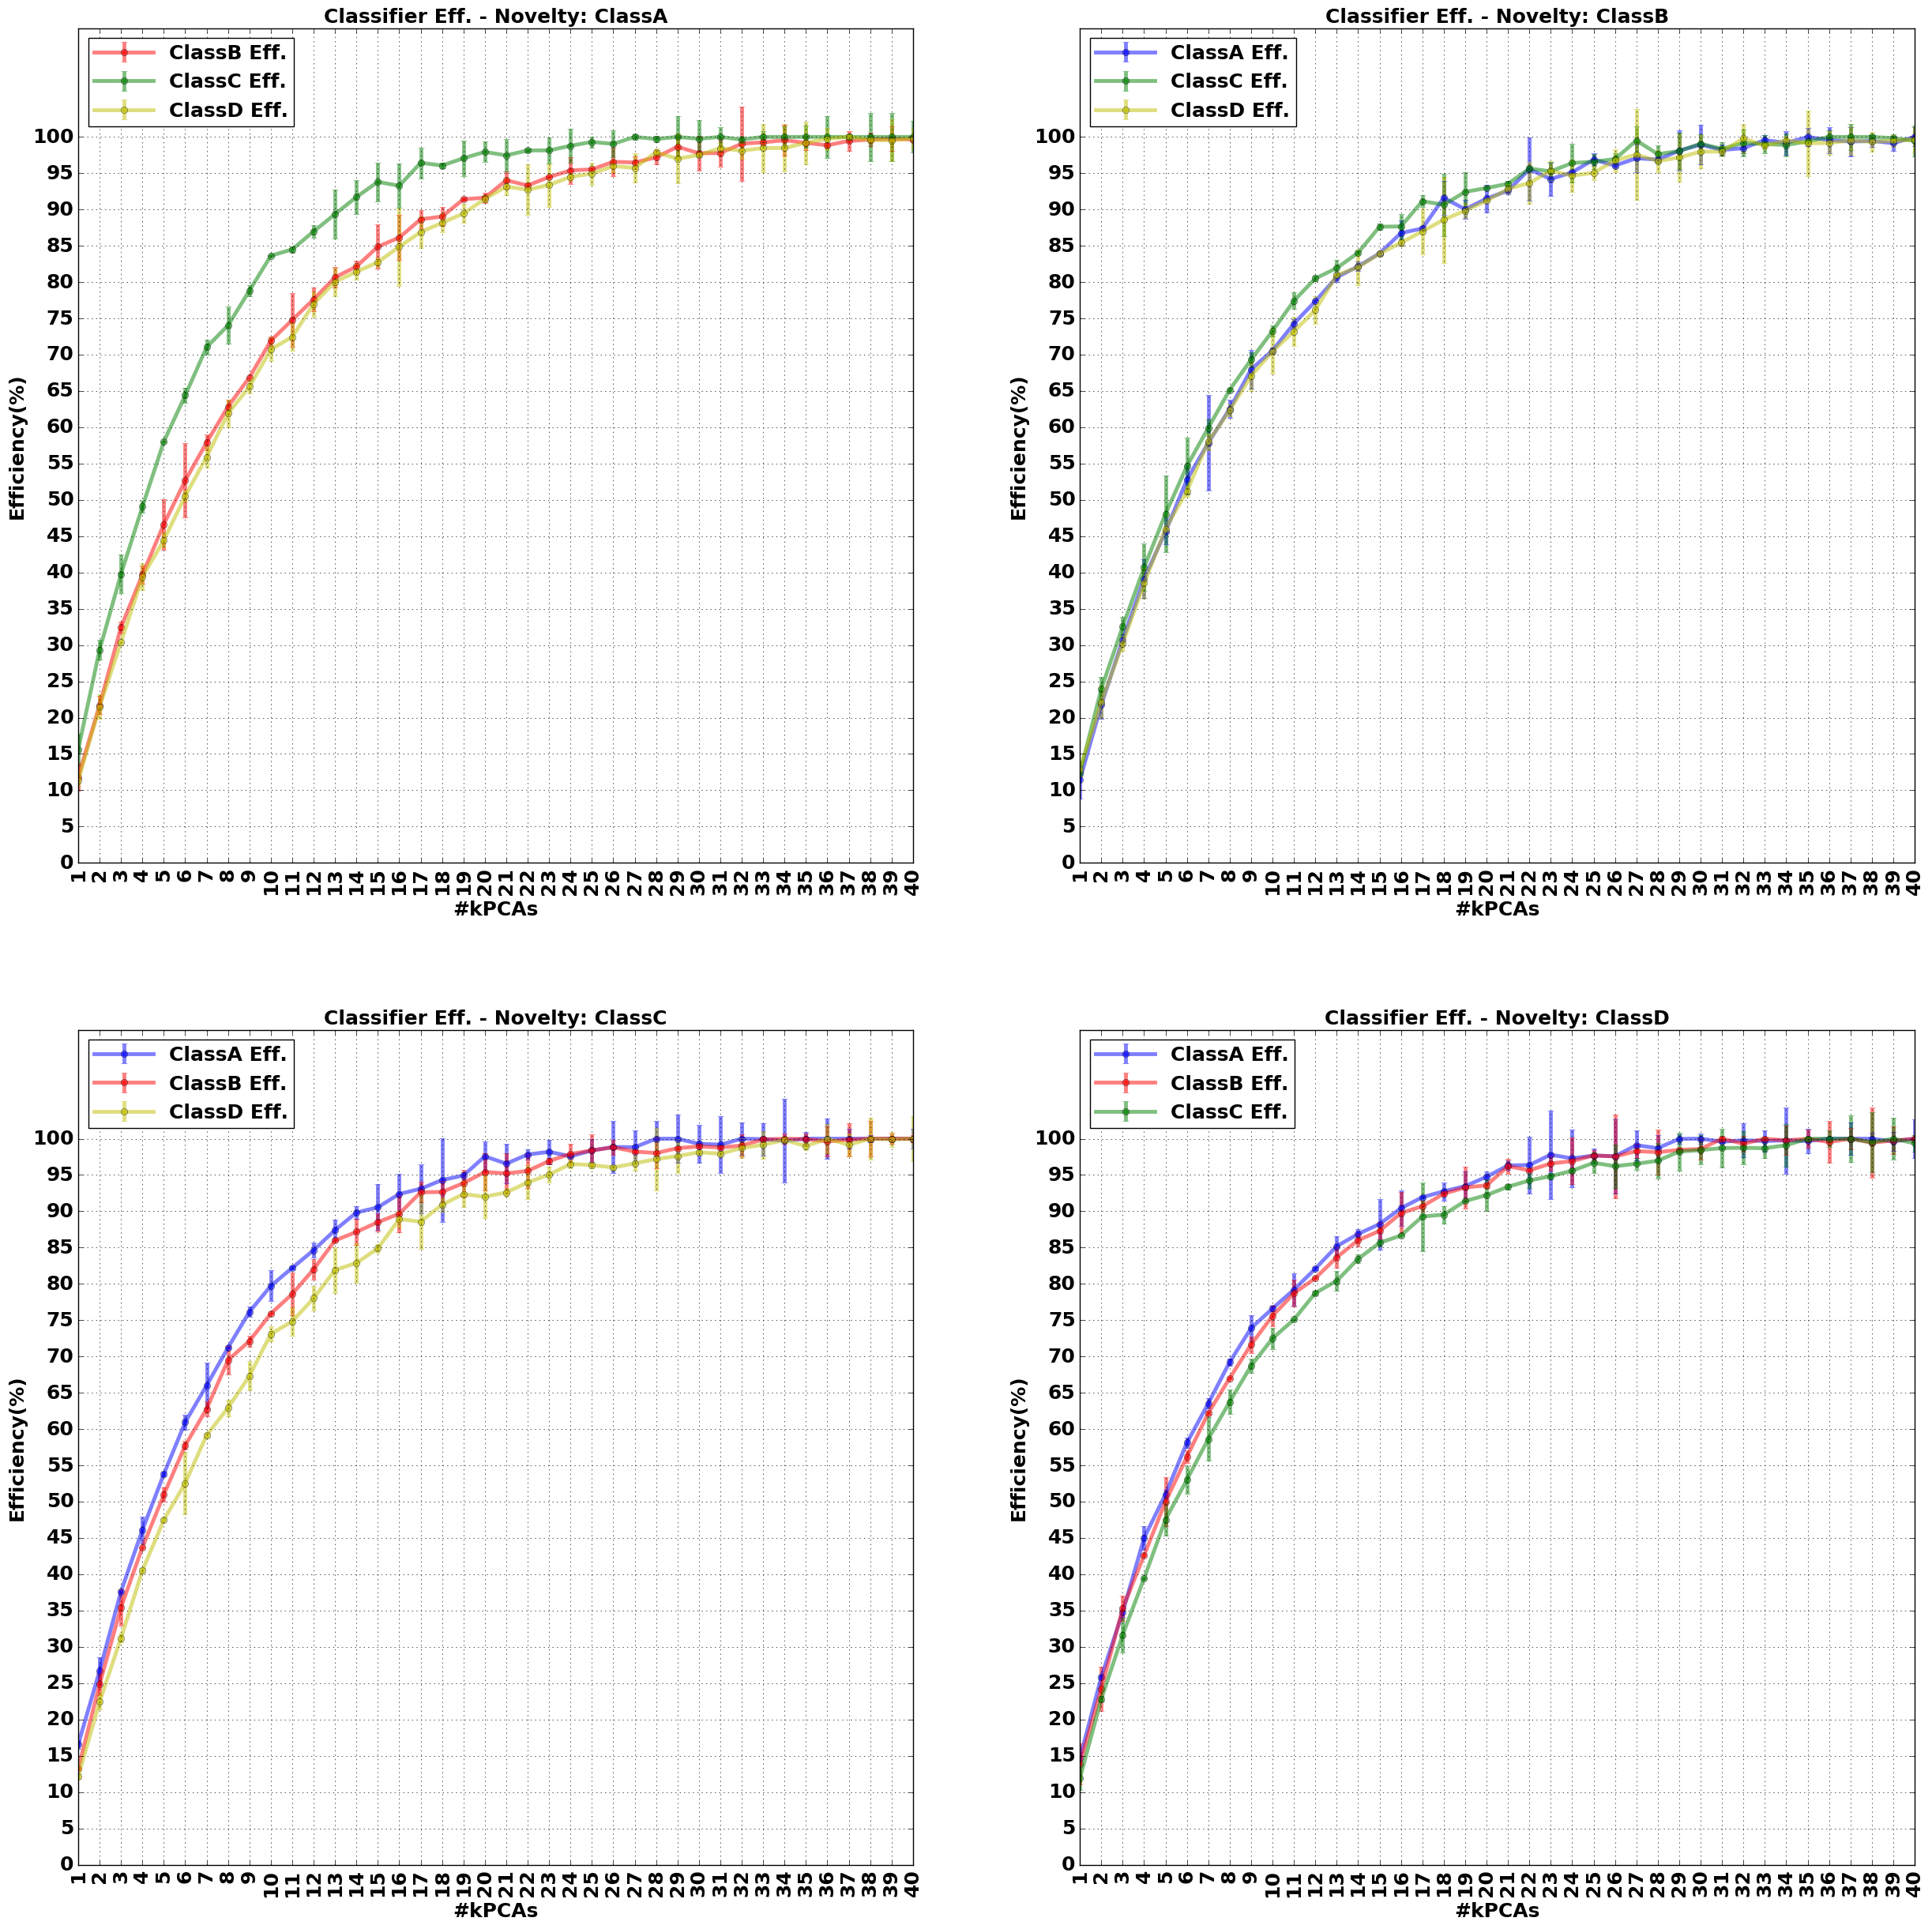

In [183]:
# generate pict of classification eff for number of kpcas

# Plot Efficiency

xvalues = np.arange(1,41,1)

fig, subplot_array = plt.subplots(nrows=2, ncols=2,figsize=(30,30))
m_colors = ['b', 'r', 'g', 'y']
for novelty_class, novelty_label in enumerate(class_labels):
    ax = plt.subplot(2,2,novelty_class+1)
    m_fontsize = 18
    plt.title('Classifier Eff. - Novelty: '+novelty_label, fontsize= m_fontsize, fontweight="bold")
    if novelty_class > -1:
        plt.xlabel('#kPCAs', fontsize= m_fontsize, fontweight="bold")
    plt.ylabel('Efficiency(%)', fontsize= m_fontsize, fontweight="bold")
    m_leg = []
        
    line_width = 3.5
    
    plot_data = {}
    
    for known_class, known_label in enumerate(class_labels):
        if known_class == novelty_class:
            continue
        
        plot_data[known_class] = (100*(1-np.exp(-xvalues/(7.5-1*np.random.randn(1,1))).T)+
                                  np.abs(np.random.randn(xvalues.shape[0],1)))
        plot_data[known_class][plot_data[known_class]>100.] = 100.0
        
    for known_class, known_label in enumerate(class_labels):
        if known_class == novelty_class:
            continue
    
        ax.errorbar(xvalues,
                    plot_data[known_class],
                    2.*np.abs(np.random.randn(xvalues.shape[0],1)),
                    marker='o',
                    color=m_colors[known_class],
                    alpha=0.5,linewidth=line_width)
        m_leg.append(known_label+' Eff.')
        
                
    # graphical assusts
    ax.set_ylim([0.0, 115])
    ax.set_yticks([x for x in range(0,101,5)])
        
    ax.set_xlim([np.min(xvalues), np.max(xvalues)])
    ax.set_xticks(xvalues)
    ax.set_xticklabels(xvalues,rotation=90)
        
    ax.grid()
    #ax.legend(m_leg, loc='upper right',ncol=2)
    ax.legend(m_leg, loc='upper left',fontsize=m_fontsize)
fig.savefig(result_analysis_path+'/picts/'+choose_date+'_'+
            log_entries[log_id]['package']+'_qtd_kpca.pdf')

In [181]:
plot_data[0][plot_data[0]>100]

array([ 101.53161237,  100.39361277,  101.46712662,  100.4756145 ])

# Treinamento - Single Class SVM
Adicionar informações
## Arquivos gerados
Adicionar informações

In [34]:
# Treinamento do detector de novidade

from sklearn import svm

%time

# Classifiers
classifiers = {}


for log_id, log_entry in enumerate(log_entries):
    if log_entries[log_id]['package'] != 'kPCASingleClassSVM':
        continue
    if log_entries[log_id]['date'] != choose_date:
        continue
    print 'kPCA analysis performed in %s and for %s analysis'%(
        log_entries[log_id]['date'],log_entries[log_id]['package'])
    
    # Read train info file
    train_info_name = '%s/train_info_files/%s_train_info.jbl'%(
        result_analysis_path,log_entries[log_id]['date'])
    
    [train_info] = joblib.load(train_info_name)
    
    # saving time
    if train_info['train_done']:
        print 'Train done, just analyse it'
        continue
    
    [kpcas] = joblib.load(result_analysis_path+'/result_files'+'/'+choose_date+'_kpca_file.jbl')
    
    for novelty_class, novelty_label in enumerate(class_labels):
        classifiers[novelty_class] = {}
        
        known_data = all_data[all_trgt!=novelty_class,:]
        known_trgt = all_trgt[all_trgt!=novelty_class]
        
        # for: folds
        for ifold in range(len(train_info['CVO_novelty_%s'%(novelty_label)])):
            classifiers[novelty_class][ifold] = {}
            
            # split data in trn set, tst set
            train_id, test_id = train_info['CVO_novelty_%s'%(novelty_label)][ifold]
            
            # normalize data based in train set
            if train_info['norm'] == 'mapstd':
                scaler = preprocessing.StandardScaler().fit(known_data[train_id,:])
            elif train_info['norm'] == 'mapstd_rob':
                scaler = preprocessing.RobustScaler().fit(known_data[train_id,:])
            elif train_info['norm'] == 'mapminmax':
                scaler = preprocessing.MinMaxScaler().fit(known_data[train_id,:])
        
            norm_known_data = scaler.transform(known_data)
        
            kpca_norm_known_data = kpcas[novelty_class][ifold].transform(norm_known_data)
            
            for nu_id, nu_value in enumerate(train_info['nu_values']):
                classifiers[novelty_class][ifold][nu_value] = {}
                print 'Training Classifiers: Novelty Class: %s, %i of %i folds, %i of %i nu_values'%(
                    novelty_label, ifold+1, len(train_info['CVO_novelty_%s'%(novelty_label)]),
                    nu_id+1, len(train_info['nu_values'])
                )
                
                # novelty detector
                novelty_detector = svm.OneClassSVM(nu=nu_value, 
                                                   kernel="rbf", 
                                                   gamma=train_info['gamma_value'])
                novelty_detector.fit(kpca_norm_known_data[train_id,:])
                
                classifiers[novelty_class][ifold][nu_value]['NoveltyDetector'] = novelty_detector
                
                # class specialist
                for known_class, known_label in enumerate(class_labels):
                    if known_class == novelty_class: continue
                    class_idx = np.nonzero(known_trgt == known_class)[0]
                    idx = np.intersect1d(class_idx,train_id)
                    classifier = svm.OneClassSVM(nu=nu_value, kernel="rbf", 
                                                 gamma=train_info['gamma_value'])
                    classifier.fit(kpca_norm_known_data[idx,:])
                    classifiers[novelty_class][ifold][nu_value][known_label] = classifier

    classifier_info_name = result_analysis_path+'/classifiers_files'+'/'+choose_date+'_classifiers.jbl'
    joblib.dump([classifiers],classifier_info_name,compress=9)

    train_info_name = result_analysis_path+'/train_info_files'+'/'+choose_date+'_train_info.jbl'

    train_info['train_done'] = True
    joblib.dump([train_info],train_info_name,compress=9)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.01 µs
kPCA analysis performed in 2017_02_12_03_31_51 and for kPCASingleClassSVM analysis
Training Classifiers: Novelty Class: ClassA, 1 of 2 folds, 1 of 11 nu_values
Training Classifiers: Novelty Class: ClassA, 1 of 2 folds, 2 of 11 nu_values
Training Classifiers: Novelty Class: ClassA, 1 of 2 folds, 3 of 11 nu_values
Training Classifiers: Novelty Class: ClassA, 1 of 2 folds, 4 of 11 nu_values
Training Classifiers: Novelty Class: ClassA, 1 of 2 folds, 5 of 11 nu_values
Training Classifiers: Novelty Class: ClassA, 1 of 2 folds, 6 of 11 nu_values
Training Classifiers: Novelty Class: ClassA, 1 of 2 folds, 7 of 11 nu_values
Training Classifiers: Novelty Class: ClassA, 1 of 2 folds, 8 of 11 nu_values
Training Classifiers: Novelty Class: ClassA, 1 of 2 folds, 9 of 11 nu_values
Training Classifiers: Novelty Class: ClassA, 1 of 2 folds, 10 of 11 nu_values
Training Classifiers: Novelty Class: ClassA, 1 of 2 folds, 11 of 11 nu_values
Trai

In [35]:
# Extração dos resultados
%time

import scipy.stats as sp_stats

for log_id, log_entry in enumerate(log_entries):
    if log_entries[log_id]['package'] != 'kPCASingleClassSVM':
        continue
    if log_entries[log_id]['date'] != choose_date:
        continue
    print 'kPCA analysis performed in %s and for %s analysis'%(
        log_entries[log_id]['date'],log_entries[log_id]['package'])
    
    # Read train info file
    train_info_name = '%s/train_info_files/%s_train_info.jbl'%(
        result_analysis_path,log_entries[log_id]['date'])
    
    [train_info] = joblib.load(train_info_name)
    
    # checking preprocessing
    if not train_info['train_done']:
        print 'Extract Preprocessing!!!'
        continue
        
    # checking training
    if not train_info['train_done']:
        print 'Perform Train!!!'
        continue
        
    # checking results extraction
    if train_info['results_done']:
        print 'Extraction done, just analyse it'
        continue
        
    [kpcas] = joblib.load(result_analysis_path+'/result_files'+'/'+choose_date+'_kpca_file.jbl')
    
    classifier_info_name = result_analysis_path+'/classifiers_files'+'/'+choose_date+'_classifiers.jbl'
    [classifiers] = joblib.load(classifier_info_name)
    
    results = {}
    
    for novelty_class, novelty_label in enumerate(class_labels):
        results[novelty_class] = {}
        
        # Class Specialist Efficiency
        for known_class, known_label in enumerate(class_labels):
            if known_class == novelty_class: continue
            results[novelty_class][known_label] = np.zeros(
                [len(train_info['nu_values']), 
                 len(train_info['CVO_novelty_%s'%(novelty_label)])])
        
        # Accuracy
        results[novelty_class]['Accuracy'] = np.zeros(
            [len(train_info['nu_values']), 
             len(train_info['CVO_novelty_%s'%(novelty_label)])]) 
        
        # Known SP
        results[novelty_class]['Known SP'] = np.zeros(
            [len(train_info['nu_values']), 
             len(train_info['CVO_novelty_%s'%(novelty_label)])])
        
        # Novelty Detection
        results[novelty_class]['Novelty Detection'] = np.zeros(
            [len(train_info['nu_values']), 
             len(train_info['CVO_novelty_%s'%(novelty_label)])])
        
        # Trigger
        results[novelty_class]['Trigger'] = np.zeros(
            [len(train_info['nu_values']), 
             len(train_info['CVO_novelty_%s'%(novelty_label)])])
       
        # for: folds
        for ifold in range(len(train_info['CVO_novelty_%s'%(novelty_label)])):
            # split data in trn set, tst set
            train_id, test_id = train_info['CVO_novelty_%s'%(novelty_label)][ifold]
            
            # normalize data based in train set
            if train_info['norm'] == 'mapstd':
                scaler = preprocessing.StandardScaler().fit(known_data[train_id,:])
            elif train_info['norm'] == 'mapstd_rob':
                scaler = preprocessing.RobustScaler().fit(known_data[train_id,:])
            elif train_info['norm'] == 'mapminmax':
                scaler = preprocessing.MinMaxScaler().fit(known_data[train_id,:])
        
            norm_all_data = scaler.transform(all_data)
        
            kpca_norm_all_data = kpcas[novelty_class][ifold].transform(norm_all_data)
            
            for nu_id, nu_value in enumerate(train_info['nu_values']):
                print 'Analysing Classifiers: Novelty Class: %s, %i of %i folds, %i of %i nu_values'%(
                    novelty_label, ifold+1, len(train_info['CVO_novelty_%s'%(novelty_label)]),
                    nu_id+1, len(train_info['nu_values'])
                )
                
                # class specialist
                for known_class, known_label in enumerate(class_labels):
                    if known_class == novelty_class: continue
                    output = (classifiers[novelty_class]
                              [ifold][nu_value]
                              [known_label].predict(kpca_norm_all_data[all_trgt==known_class]))
                    
                    results[novelty_class][known_label][nu_id,ifold] = (
                    float(sum(output==1))/float(output.shape[0]))
                
                # accuracy
                buff = np.zeros([len(class_labels)-1,1])
                for known_class, known_label in enumerate(class_labels):
                    if known_class == novelty_class: continue
                    buff[known_class-(known_class>novelty_class)] = (
                        results[novelty_class][known_label][nu_id,ifold])
                results[novelty_class]['Accuracy'][nu_id,ifold] = np.mean(buff,axis=0)
                
                # known sp
                results[novelty_class]['Known SP'][nu_id,ifold] = (np.sqrt(np.mean(buff,axis=0)
                                                                           *sp_stats.gmean(buff,axis=0)))
                
                # novelty detection
                output = (classifiers[novelty_class]
                          [ifold][nu_value]
                          ['NoveltyDetector'].predict(kpca_norm_all_data
                                                [all_trgt==novelty_class]))
                results[novelty_class]['Novelty Detection'][nu_id,ifold] = (
                float(sum(output==-1))/float(output.shape[0]))
                
                # trigger
                output = (classifiers[novelty_class]
                          [ifold][nu_value]
                          ['NoveltyDetector'].predict(kpca_norm_all_data
                                                [all_trgt!=novelty_class]))
                results[novelty_class]['Trigger'][nu_id,ifold] = (
                float(sum(output==1))/float(output.shape[0]))
                
    result_file_path = result_analysis_path+'/result_files'+'/'+choose_date+'_results.jbl'
    joblib.dump([results],result_file_path,compress=9)

    train_info_name = result_analysis_path+'/train_info_files'+'/'+choose_date+'_train_info.jbl'

    train_info['results_done'] = True
    joblib.dump([train_info],train_info_name,compress=9)

CPU times: user 0 ns, sys: 2 µs, total: 2 µs
Wall time: 2.86 µs
kPCA analysis performed in 2017_02_12_03_31_51 and for kPCASingleClassSVM analysis
Analysing Classifiers: Novelty Class: ClassA, 1 of 2 folds, 1 of 11 nu_values
Analysing Classifiers: Novelty Class: ClassA, 1 of 2 folds, 2 of 11 nu_values
Analysing Classifiers: Novelty Class: ClassA, 1 of 2 folds, 3 of 11 nu_values
Analysing Classifiers: Novelty Class: ClassA, 1 of 2 folds, 4 of 11 nu_values
Analysing Classifiers: Novelty Class: ClassA, 1 of 2 folds, 5 of 11 nu_values
Analysing Classifiers: Novelty Class: ClassA, 1 of 2 folds, 6 of 11 nu_values
Analysing Classifiers: Novelty Class: ClassA, 1 of 2 folds, 7 of 11 nu_values
Analysing Classifiers: Novelty Class: ClassA, 1 of 2 folds, 8 of 11 nu_values
Analysing Classifiers: Novelty Class: ClassA, 1 of 2 folds, 9 of 11 nu_values
Analysing Classifiers: Novelty Class: ClassA, 1 of 2 folds, 10 of 11 nu_values
Analysing Classifiers: Novelty Class: ClassA, 1 of 2 folds, 11 of 11 nu_

CPU times: user 8 µs, sys: 4 µs, total: 12 µs
Wall time: 13.8 µs
kPCA analysis performed in 2017_02_12_03_31_51 and for kPCASingleClassSVM analysis


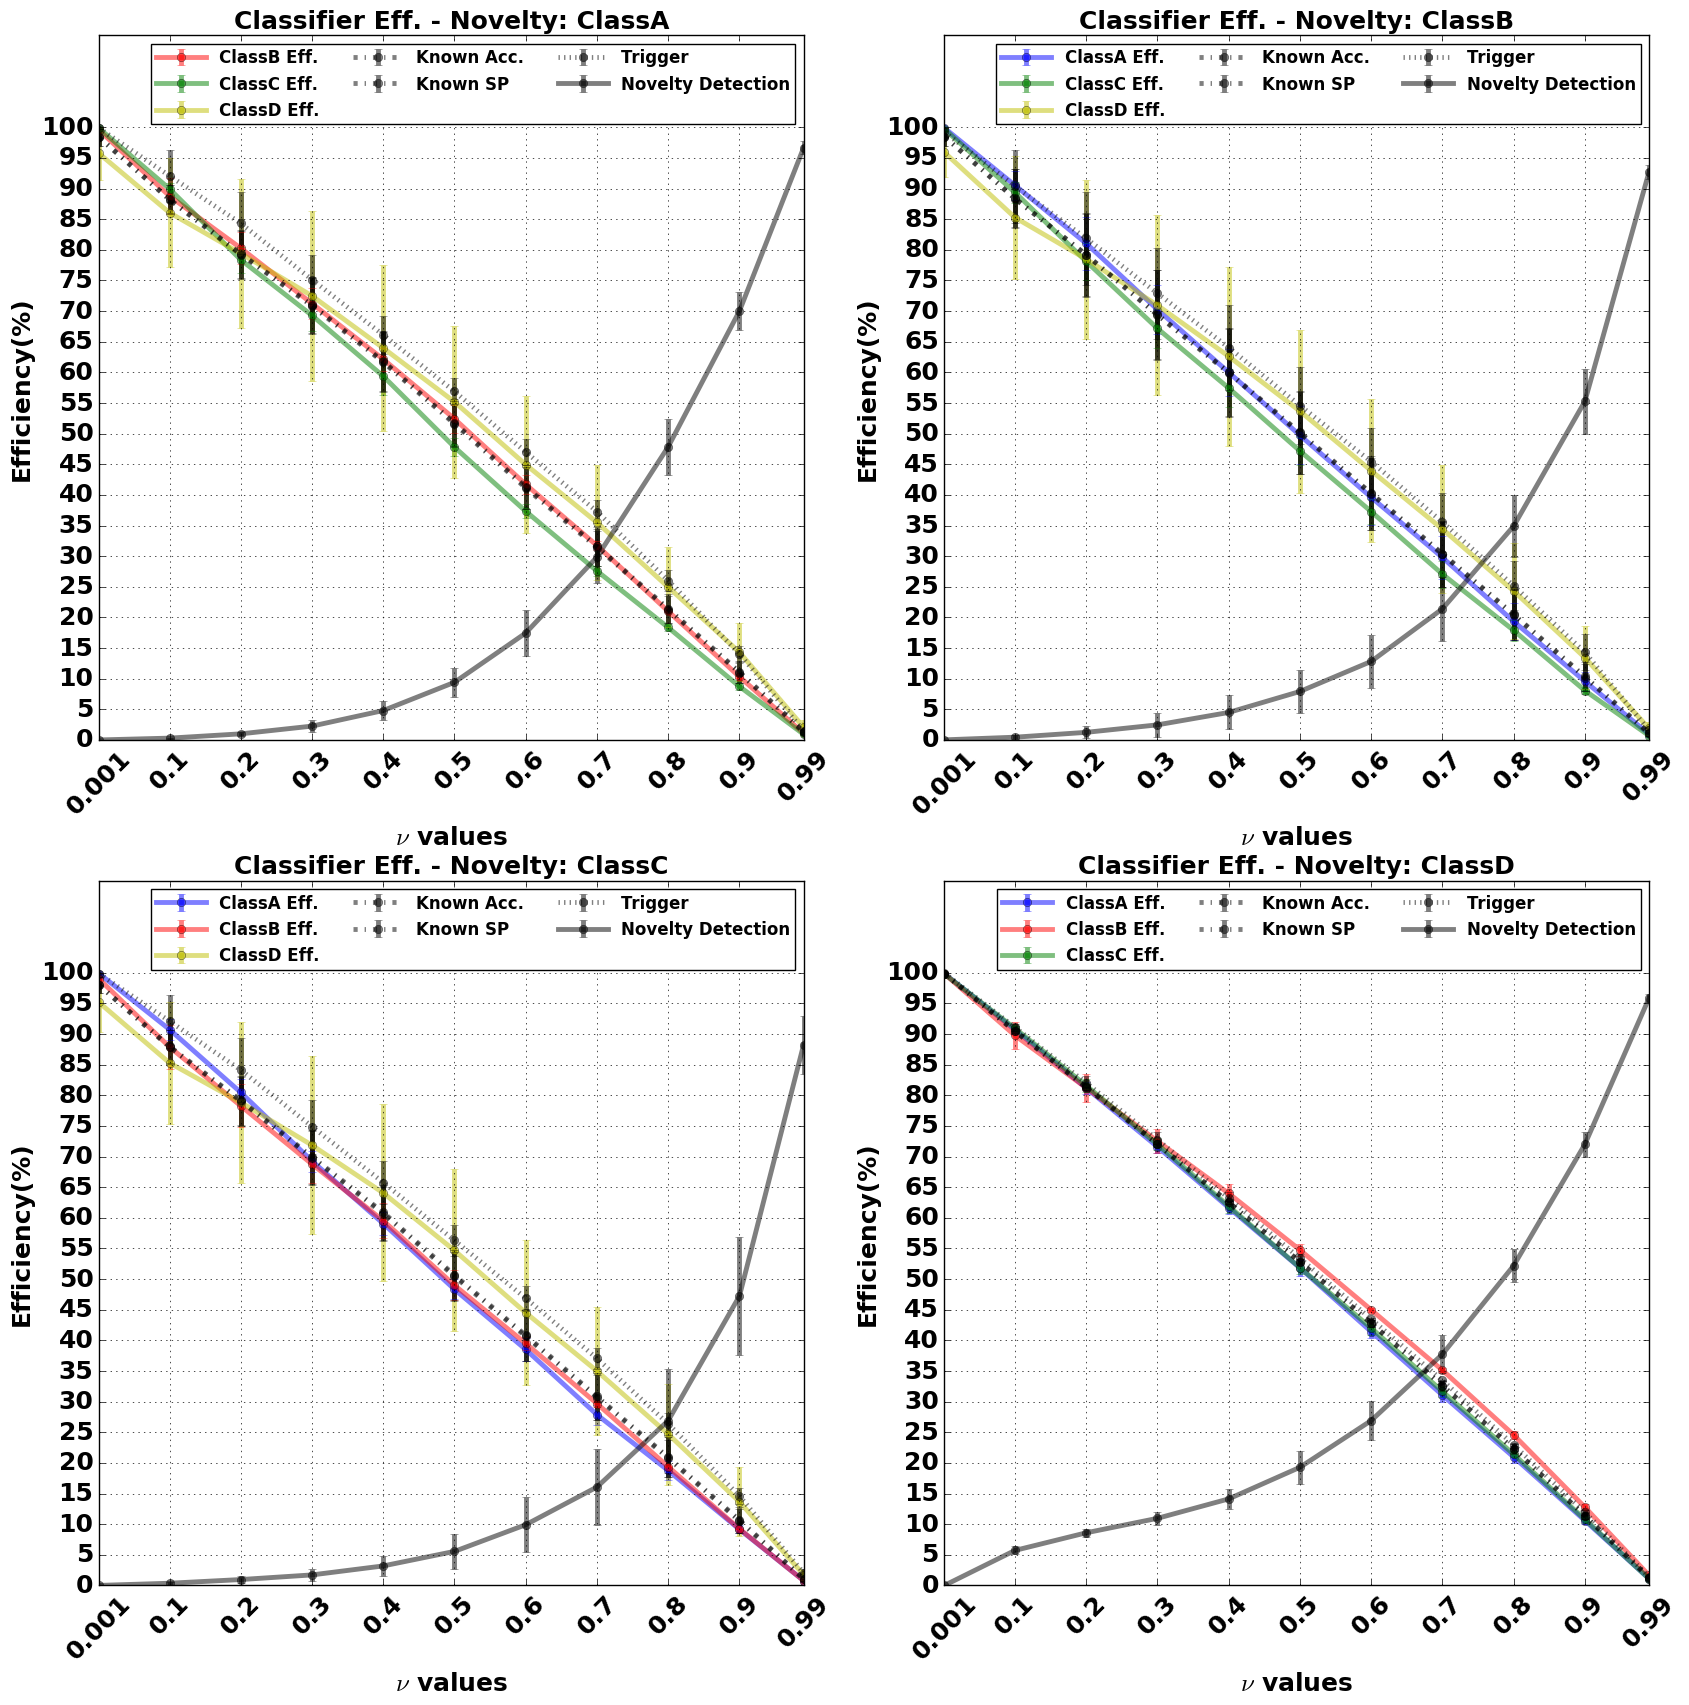

In [156]:
# Analise dos resultados
%time

import matplotlib.pyplot as plt

plt.rcParams['font.weight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['legend.numpoints'] = 1
plt.rcParams['legend.handlelength'] = 3
plt.rcParams['legend.borderpad'] = 0.3

%matplotlib inline

for log_id, log_entry in enumerate(log_entries):
    if log_entries[log_id]['package'] != 'kPCASingleClassSVM':
        continue
    if log_entries[log_id]['date'] != choose_date:
        continue
    print 'kPCA analysis performed in %s and for %s analysis'%(
        log_entries[log_id]['date'],log_entries[log_id]['package'])
    
    # Read train info file
    train_info_name = '%s/train_info_files/%s_train_info.jbl'%(
        result_analysis_path,log_entries[log_id]['date'])
    
    [train_info] = joblib.load(train_info_name)
    
    # checking preprocessing
    if not train_info['train_done']:
        print 'Extract Preprocessing!!!'
        continue
        
    # checking training
    if not train_info['train_done']:
        print 'Perform Train!!!'
        continue
        
    # checking results extraction
    if not train_info['results_done']:
        print 'Perform Extraction!!!'
        continue
        
    [kpcas] = joblib.load(result_analysis_path+'/result_files'+'/'+choose_date+'_kpca_file.jbl')
    
    classifier_info_name = result_analysis_path+'/classifiers_files'+'/'+choose_date+'_classifiers.jbl'
    [classifiers] = joblib.load(classifier_info_name)
    
    result_file_path = result_analysis_path+'/result_files'+'/'+choose_date+'_results.jbl'
    [results] = joblib.load(result_file_path)
    
    # Plot Efficiency
    fig, subplot_array = plt.subplots(nrows=2, ncols=2,figsize=(20,20))
    m_colors = ['b', 'r', 'g', 'y']
    for novelty_class, novelty_label in enumerate(class_labels):
        ax = plt.subplot(2,2,novelty_class+1)
        m_fontsize = 18
        plt.title('Classifier Eff. - Novelty: '+novelty_label, fontsize= m_fontsize, fontweight="bold")
        if novelty_class > -1:
            plt.xlabel(r'$\nu$ values', fontsize= m_fontsize, fontweight="bold")
        plt.ylabel('Efficiency(%)', fontsize= m_fontsize, fontweight="bold")
        m_leg = []
        
        line_width = 3.5
        
        # class specialist eff
        for known_class, known_label in enumerate(class_labels):
            if known_class == novelty_class: continue
            plot_data = results[novelty_class][known_label]
            ax.errorbar(train_info['nu_values'],
                        100*np.mean(plot_data,axis=1),
                        100*np.std(plot_data,axis=1),marker='o',
                        color=m_colors[known_class],alpha=0.5,linewidth=line_width)
            m_leg.append(known_label+' Eff.')
        
        # accuracy
        plot_data = results[novelty_class]['Accuracy']
        ax.errorbar(train_info['nu_values'],
                    100*np.mean(plot_data,axis=1),
                    100*np.std(plot_data,axis=1),marker='o',
                    color='k',ls='-.',alpha=0.5, linewidth=line_width)
        m_leg.append('Known Acc.')
        
        # known sp
        plot_data = results[novelty_class]['Known SP']
        ax.errorbar(train_info['nu_values'],
                    100*np.mean(plot_data,axis=1),
                    100*np.std(plot_data,axis=1),marker='o',
                    color='k',ls='-.',alpha=0.5, linewidth=line_width)
        m_leg.append('Known SP')
        
        # trigger
        plot_data = results[novelty_class]['Trigger']
        ax.errorbar(train_info['nu_values'],
                    100*np.mean(plot_data,axis=1),
                    100*np.std(plot_data,axis=1),marker='o',
                    color='k',ls=':',alpha=0.5, linewidth=line_width)
        m_leg.append('Trigger')
        
        # novelty detection
        plot_data = results[novelty_class]['Novelty Detection']
        ax.errorbar(train_info['nu_values'],
                    100*np.mean(plot_data,axis=1),
                    100*np.std(plot_data,axis=1),marker='o',
                    color='k',ls='-',alpha=0.5, linewidth=line_width)
        m_leg.append('Novelty Detection')
        
        # graphical assusts
        ax.set_ylim([0.0, 115])
        ax.set_yticks([x for x in range(0,101,5)])
        
        ax.set_xlim([np.min(train_info['nu_values']), np.max(train_info['nu_values'])])
        ax.set_xticks(train_info['nu_values'])
        ax.set_xticklabels(train_info['nu_values'],rotation=45)
        
        ax.grid()
        ax.legend(m_leg, loc='upper right',ncol=3)
    fig.savefig(result_analysis_path+'/picts/'+choose_date+'_'+
                log_entries[log_id]['package']+'_novelty_detection.pdf')